# ANALISE ESTATISTICA BUSINESS CASE UNIMED

## 1. IMPORT BIBLIOTECA

In [141]:
import pandas as pd
import numpy as np
import pyodbc
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin


## 2. CONFIGURAR CONEXÃO COM O BANCO DE DADOS

In [142]:
SERVER = 'ADIR'
DATABASE = 'BUSINESS'

In [143]:
conn_str = (
    f'DRIVER={{ODBC Driver 17 for SQL Server}};'
    f'SERVER={SERVER};'
    f'DATABASE={DATABASE};'
    'Trusted_Connection=yes;'           
    'Encrypt=yes;'                      
    'TrustServerCertificate=yes;'       
)

In [144]:
with pyodbc.connect(conn_str) as conn:
    cursor = conn.cursor()
    cursor.execute('SELECT * FROM dbo.Staging_Beneficiarios')

In [145]:
query = '''
    SELECT DISTINCT * 
    FROM dbo.Staging_Beneficiarios 
    WHERE D_CMPT_MOVEL = '2025-01'
'''

df = pd.read_sql(query, conn)

## 3. PRÉ TRATAMENTO DOS DADOS

In [146]:
df.head()

,ID_Staging,D_CMPT_MOVEL,CD_OPERADORA,NM_RAZAO_SOCIAL,NR_CNPJ,MODALIDADE_OPERADORA,SG_UF,CD_MUNICIPIO,NM_MUNICIPIO,TP_SEXO,...,TP_VIGENCIA_PLANO,DE_CONTRATACAO_PLANO,DE_SEGMENTACAO_PLANO,DE_ABRG_GEOGRAFICA_PLANO,COBERTURA_ASSIST_PLAN,TIPO_VINCULO,QT_BENEFICIARIO_ATIVO,QT_BENEFICIARIO_ADERIDO,QT_BENEFICIARIO_CANCELADO,DT_CARGA
0,1,2025-01,371254,UNIMED REGIONAL MARINGÁ COOP.DE TRABALHO MÉDICO,76767219000182,COOPERATIVA MÉDICA,PR,411420,Mandaguari,M,...,P,Coletivo Empresarial,Ambulatorial + Hospitalar com obstetrícia,Nacional,Médico-hospitalar,Dependente,1,0,0,2025-02-28
1,2,2025-01,336831,IRMANDADE SANTA CASA DE MISERICÓRDIA DE MARINGÁ,79115762000193,FILANTROPIA,PR,411520,Maringá,F,...,P,Individual ou Familiar,Ambulatorial + Hospitalar com obstetrícia,Grupo de municípios,Médico-hospitalar,Dependente,15,0,0,2025-02-28
2,3,2025-01,416401,CAIXA DE ASSISTÊNCIA DOS EMPREGADOS DA EMPRESA...,8097092000181,AUTOGESTÃO,PR,411370,Londrina,M,...,P,Coletivo Empresarial,Ambulatorial + Hospitalar com obstetrícia,Nacional,Médico-hospitalar,Titular,22,0,0,2025-02-28
3,4,2025-01,371254,UNIMED REGIONAL MARINGÁ COOP.DE TRABALHO MÉDICO,76767219000182,COOPERATIVA MÉDICA,PR,411750,Paiçandu,F,...,P,Coletivo Empresarial,Ambulatorial + Hospitalar com obstetrícia,Grupo de municípios,Médico-hospitalar,Titular,12,0,1,2025-02-28
4,5,2025-01,304484,DENTAL UNI - COOPERATIVA ODONTOLÓGICA,78738101000151,COOPERATIVA ODONTOLÓGICA,PR,410580,Colombo,M,...,P,Individual ou Familiar,Odontológico,Estadual,Odontológico,Titular,10,0,0,2025-02-28


In [147]:
df.dtypes

ID_Staging                    int64
D_CMPT_MOVEL                 object
CD_OPERADORA                  int64
NM_RAZAO_SOCIAL              object
NR_CNPJ                      object
MODALIDADE_OPERADORA         object
SG_UF                        object
CD_MUNICIPIO                  int64
NM_MUNICIPIO                 object
TP_SEXO                      object
DE_FAIXA_ETARIA              object
DE_FAIXA_ETARIA_REAJ         object
CD_PLANO                     object
TP_VIGENCIA_PLANO            object
DE_CONTRATACAO_PLANO         object
DE_SEGMENTACAO_PLANO         object
DE_ABRG_GEOGRAFICA_PLANO     object
COBERTURA_ASSIST_PLAN        object
TIPO_VINCULO                 object
QT_BENEFICIARIO_ATIVO         int64
QT_BENEFICIARIO_ADERIDO       int64
QT_BENEFICIARIO_CANCELADO     int64
DT_CARGA                     object
dtype: object

In [148]:
df['DT_CARGA']

0          2025-02-28
1          2025-02-28
2          2025-02-28
3          2025-02-28
4          2025-02-28
              ...    
2617363    2025-02-28
2617364    2025-02-28
2617365    2025-02-28
2617366    2025-02-28
2617367    2025-02-28
Name: DT_CARGA, Length: 2617368, dtype: object

## 4. DEFINIÇÃO DAS VARIÁVEIS ALVO E VARIAVEIS EXPLICATIVAS

In [149]:
df = df[
    [
        'NM_RAZAO_SOCIAL',
        'MODALIDADE_OPERADORA',
        'SG_UF',
        'NM_MUNICIPIO',
        'TP_SEXO',
        'DE_FAIXA_ETARIA',
        'DE_FAIXA_ETARIA_REAJ',
        'TP_VIGENCIA_PLANO',
        'DE_CONTRATACAO_PLANO',
        'DE_SEGMENTACAO_PLANO',
        'DE_ABRG_GEOGRAFICA_PLANO',
        'COBERTURA_ASSIST_PLAN',
        'TIPO_VINCULO',
        'QT_BENEFICIARIO_ATIVO',
        'QT_BENEFICIARIO_ADERIDO',
        'QT_BENEFICIARIO_CANCELADO'
    ]
]

In [150]:
df.head()

,NM_RAZAO_SOCIAL,MODALIDADE_OPERADORA,SG_UF,NM_MUNICIPIO,TP_SEXO,DE_FAIXA_ETARIA,DE_FAIXA_ETARIA_REAJ,TP_VIGENCIA_PLANO,DE_CONTRATACAO_PLANO,DE_SEGMENTACAO_PLANO,DE_ABRG_GEOGRAFICA_PLANO,COBERTURA_ASSIST_PLAN,TIPO_VINCULO,QT_BENEFICIARIO_ATIVO,QT_BENEFICIARIO_ADERIDO,QT_BENEFICIARIO_CANCELADO
0,UNIMED REGIONAL MARINGÁ COOP.DE TRABALHO MÉDICO,COOPERATIVA MÉDICA,PR,Mandaguari,M,15 a 17 anos,0 a 18 anos,P,Coletivo Empresarial,Ambulatorial + Hospitalar com obstetrícia,Nacional,Médico-hospitalar,Dependente,1,0,0
1,IRMANDADE SANTA CASA DE MISERICÓRDIA DE MARINGÁ,FILANTROPIA,PR,Maringá,F,65 a 69 anos,59 ou mais,P,Individual ou Familiar,Ambulatorial + Hospitalar com obstetrícia,Grupo de municípios,Médico-hospitalar,Dependente,15,0,0
2,CAIXA DE ASSISTÊNCIA DOS EMPREGADOS DA EMPRESA...,AUTOGESTÃO,PR,Londrina,M,65 a 69 anos,59 ou mais,P,Coletivo Empresarial,Ambulatorial + Hospitalar com obstetrícia,Nacional,Médico-hospitalar,Titular,22,0,0
3,UNIMED REGIONAL MARINGÁ COOP.DE TRABALHO MÉDICO,COOPERATIVA MÉDICA,PR,Paiçandu,F,45 a 49 anos,44 a 48 anos,P,Coletivo Empresarial,Ambulatorial + Hospitalar com obstetrícia,Grupo de municípios,Médico-hospitalar,Titular,12,0,1
4,DENTAL UNI - COOPERATIVA ODONTOLÓGICA,COOPERATIVA ODONTOLÓGICA,PR,Colombo,M,50 a 54 anos,54 a 58 anos,P,Individual ou Familiar,Odontológico,Estadual,Odontológico,Titular,10,0,0


In [151]:
df.describe()

,QT_BENEFICIARIO_ATIVO,QT_BENEFICIARIO_ADERIDO,QT_BENEFICIARIO_CANCELADO
count,2.617368e+06,2.617368e+06,2.617368e+06
mean,4.396500e+00,9.426493e-02,9.586233e-02
std,2.316418e+01,7.637103e-01,7.886204e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00,0.000000e+00
75%,3.000000e+00,0.000000e+00,0.000000e+00
max,6.170000e+03,1.260000e+02,1.290000e+02


A analise será conduzida pela variavel alvo risco chun com base em QT_BENEFICIARIO_CANCELADO buscando explicação a priori pelas variáveis alvos: 
NM_RAZAO_SOCIAL
MODALIDADE_OPERADORA
SG_UF
MUNICIPIO
TP_SEXO
DE_FAIXA_ETARIA
DE_FAIXA_ETARIA_REAJ
TP_VIGENCIA_PLANO
DE_CONTRATACAO_PLANO
DE_SEGMENTACAO_PLANO
DE_ABRG_GEOGRAFICA_PLANO
COBERTURA_ASSIST_PLAN
TIPO_VINCULO
QT_BENEFICIARIO_ATIVO
QT_BENEFICIARIO_ADERIDO
QT_BENEFICIARIO_CANCELADO após isso julgarei a necesidade de incluir novos dados ou a criação de novas features, essse processo é importante para definirmos quais variaveis melhor explicam a variável alvo

## 5. PRÉ TRATAMENTO DOS DADOS

### 5.1. análise dos dados zerados

In [152]:
df['ATIVO_CAT'] = df['QT_BENEFICIARIO_ATIVO'].apply(lambda x: '0' if x == 0 else '>0')
df['ADERIDO_CAT'] = df['QT_BENEFICIARIO_ADERIDO'].apply(lambda x: '0' if x == 0 else '>0')

In [153]:
crosstab = pd.crosstab(
    index=df['ATIVO_CAT'], 
    columns=[df['ADERIDO_CAT']],
    values=df['QT_BENEFICIARIO_CANCELADO'],
    aggfunc='sum',
    margins=True,  # Adiciona totais
    margins_name="Total"
)

# Resultado
print(crosstab)

ADERIDO_CAT       0     >0   Total
ATIVO_CAT                         
0             67561    110   67671
>0           108255  74981  183236
Total        175816  75091  250907


In [154]:
df_inconsistentes = df[(df['QT_BENEFICIARIO_ATIVO'] == 0) & (df['QT_BENEFICIARIO_CANCELADO'] > 0)]

In [155]:
df_inconsistentes

,NM_RAZAO_SOCIAL,MODALIDADE_OPERADORA,SG_UF,NM_MUNICIPIO,TP_SEXO,DE_FAIXA_ETARIA,DE_FAIXA_ETARIA_REAJ,TP_VIGENCIA_PLANO,DE_CONTRATACAO_PLANO,DE_SEGMENTACAO_PLANO,DE_ABRG_GEOGRAFICA_PLANO,COBERTURA_ASSIST_PLAN,TIPO_VINCULO,QT_BENEFICIARIO_ATIVO,QT_BENEFICIARIO_ADERIDO,QT_BENEFICIARIO_CANCELADO,ATIVO_CAT,ADERIDO_CAT
11,UNIMED FOZ DO IGUACU COOPERATIVA TRABALHO MEDICO,COOPERATIVA MÉDICA,PR,Foz do Iguaçu,F,40 a 44 anos,39 a 43 anos,P,Coletivo por Adesão,Ambulatorial + Hospitalar com obstetrícia,Municipal,Médico-hospitalar,Titular,0,0,11,0,0
48,UNIMED FOZ DO IGUACU COOPERATIVA TRABALHO MEDICO,COOPERATIVA MÉDICA,PR,Foz do Iguaçu,M,55 a 59 anos,54 a 58 anos,P,Individual ou Familiar,Ambulatorial + Hospitalar sem obstetrícia,Estadual,Médico-hospitalar,Titular,0,0,13,0,0
49,METLIFE PLANOS ODONTOLÓGICOS LTDA.,ODONTOLOGIA DE GRUPO,PR,Londrina,F,45 a 49 anos,44 a 48 anos,P,Individual ou Familiar,Odontológico,Nacional,Odontológico,Titular,0,0,6,0,0
104,UNIMED FOZ DO IGUACU COOPERATIVA TRABALHO MEDICO,COOPERATIVA MÉDICA,PR,Foz do Iguaçu,F,50 a 54 anos,54 a 58 anos,P,Individual ou Familiar,Ambulatorial + Hospitalar sem obstetrícia,Estadual,Médico-hospitalar,Dependente,0,0,3,0,0
144,UNIMED FOZ DO IGUACU COOPERATIVA TRABALHO MEDICO,COOPERATIVA MÉDICA,PR,Foz do Iguaçu,F,35 a 39 anos,34 a 38 anos,P,Coletivo Empresarial,Ambulatorial + Hospitalar com obstetrícia,Municipal,Médico-hospitalar,Titular,0,0,11,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2617289,SAMEDIL SERVIÇOS DE ATENDIMENTO MÉDICO S/A,MEDICINA DE GRUPO,RS,Cachoeirinha,F,40 a 44 anos,44 a 48 anos,P,Individual ou Familiar,Ambulatorial + Hospitalar sem obstetrícia,Municipal,Médico-hospitalar,Titular,0,0,1,0,0
2617302,UNIMED SEGUROS SAÚDE S/A,SEGURADORA ESPECIALIZADA EM SAÚDE,RS,Montenegro,M,55 a 59 anos,54 a 58 anos,P,Coletivo Empresarial,Ambulatorial + Hospitalar com obstetrícia,Nacional,Médico-hospitalar,Titular,0,0,1,0,0
2617342,BRADESCO SAÚDE S.A.,SEGURADORA ESPECIALIZADA EM SAÚDE,RS,Horizontina,F,30 a 34 anos,29 a 33 anos,P,Coletivo Empresarial,Ambulatorial + Hospitalar com obstetrícia,Nacional,Médico-hospitalar,Dependente,0,0,1,0,0
2617343,UNIMED NACIONAL - COOPERATIVA CENTRAL,COOPERATIVA MÉDICA,RS,Porto Alegre,M,30 a 34 anos,34 a 38 anos,P,Coletivo Empresarial,Ambulatorial + Hospitalar com obstetrícia,Municipal,Médico-hospitalar,Titular,0,0,1,0,0


In [156]:
df_filtrado = df[(df['QT_BENEFICIARIO_ATIVO'] == 0) & (df['QT_BENEFICIARIO_CANCELADO'] > 0)]
proportion = df_filtrado.shape[0] / df.shape[0]
print(proportion)

0.016006155802317443


pelo comportamento estranho e pela baixa representatitividade dentro da database estou excluindo as linhas que possuem QT_BENEFICIARIO_ATIVO igual a 0 e QT_BENEFICIARIO_CANCELADO maior que 0.

In [157]:
df.shape[0]

2617368

In [158]:
df = df[~((df['QT_BENEFICIARIO_ATIVO'] == 0) & (df['QT_BENEFICIARIO_CANCELADO'] > 0))]

In [159]:
df.shape[0]

2575474

In [160]:
df.dtypes

NM_RAZAO_SOCIAL              object
MODALIDADE_OPERADORA         object
SG_UF                        object
NM_MUNICIPIO                 object
TP_SEXO                      object
DE_FAIXA_ETARIA              object
DE_FAIXA_ETARIA_REAJ         object
TP_VIGENCIA_PLANO            object
DE_CONTRATACAO_PLANO         object
DE_SEGMENTACAO_PLANO         object
DE_ABRG_GEOGRAFICA_PLANO     object
COBERTURA_ASSIST_PLAN        object
TIPO_VINCULO                 object
QT_BENEFICIARIO_ATIVO         int64
QT_BENEFICIARIO_ADERIDO       int64
QT_BENEFICIARIO_CANCELADO     int64
ATIVO_CAT                    object
ADERIDO_CAT                  object
dtype: object

### 5.2. análise dos dados inconsistentes

In [161]:
df['NM_MUNICIPIO'].value_counts()

NM_MUNICIPIO
Curitiba                   112995
Porto Alegre                83073
Florianópolis               54406
Joinville                   50311
Londrina                    46062
                            ...  
Município ignorado - RS        35
Pedras Altas                   34
São Pedro das Missões          32
Porto Vera Cruz                27
Município ignorado - SC        12
Name: count, Length: 1181, dtype: int64

In [162]:
df = df[~df['NM_MUNICIPIO'].isin(['Município ignorado - RS', 'Município ignorado - SC', 'Município ignorado - PR'])]

In [163]:
df = df[~df['DE_FAIXA_ETARIA_REAJ'].isin(['Informada Incorr'])]

In [164]:
df=df[~df['DE_CONTRATACAO_PLANO'].isin(['Não Identificado'])]

In [165]:
df=df[~df['DE_ABRG_GEOGRAFICA_PLANO'].isin(['Outra'])]

In [166]:
df=df[~df['TIPO_VINCULO'].isin(['Não Identificado'])]

pelas  baixas representatitividas foi limpado dados das colunas NM_MUNICIPIO, DE_FAIXA_ETARIA_REAJ, DE_CONTRATACAO_PLANO, DE_ABRG_GEOGRAFICA_PLANO, TIPO_VINCULO

## 6. FEATURE ENGINEERING

### 6.1. DADOS DEMOGRÁFICOS

#### 6.1.1 Função faixa etária

In [167]:
def categorizar_faixa_etaria(faixa):
    if faixa in ['Zero anos', '1 a 4 anos', '5 a 9 anos', '10 a 14 anos', '15 a 17 anos', '18 a 19 anos', '20 a 24 anos']:
        return 'Jovem'
    elif faixa in ['25 a 29 anos', '30 a 34 anos', '35 a 39 anos', '40 a 44 anos', '45 a 49 anos', '50 a 54 anos', '55 a 59 anos']:
        return 'Adulto'
    elif faixa in ['60 a 64 anos', '65 a 69 anos', '70 a 74 anos', '75 a 79 anos', '80 ou mais']:
        return 'Idoso'
    else:
        return 'Outros'

df['FAIXA_ETARIA_CAT'] = df['DE_FAIXA_ETARIA'].apply(categorizar_faixa_etaria)

# Contar beneficiários por categoria
contagem = df['FAIXA_ETARIA_CAT'].value_counts()
print(contagem)

FAIXA_ETARIA_CAT
Adulto    1497092
Jovem      704844
Idoso      372251
Name: count, dtype: int64


In [168]:
df['FAIXA_ETARIA_CAT'].value_counts

<bound method IndexOpsMixin.value_counts of 0           Jovem
1           Idoso
2           Idoso
3          Adulto
4          Adulto
            ...  
2617363    Adulto
2617364    Adulto
2617365     Jovem
2617366     Idoso
2617367     Jovem
Name: FAIXA_ETARIA_CAT, Length: 2574187, dtype: object>

In [169]:
df['SEXO_BINARIO'] = df['TP_SEXO'].map({'M': 1, 'F': 0})

In [170]:
df['SEXO_BINARIO'].value_counts()

SEXO_BINARIO
0    1332283
1    1241904
Name: count, dtype: int64

### 6.2. DADOS DO PLANO

#### 6.2.1 CATEGORIZAÇÃO DO MODELO DE CONTRATAÇÃO DO PLANO

In [171]:
print(df['DE_CONTRATACAO_PLANO'].unique())

['Coletivo Empresarial' 'Individual ou Familiar' 'Coletivo por Adesão'
 'Coletivo por Adesão com patrocínio'
 'Coletivo Empresarial com patrocínio'
 'Individual ou Familiar + Coletivo Empresarial']


In [172]:
mapeamento = {
    'Individual ou Familiar': 0,
    'Coletivo Empresarial': 1,
    'Coletivo por Adesão': 1,
    'Coletivo por Adesão com patrocínio': 1,
    'Coletivo Empresarial com patrocínio': 1,
    'Individual ou Familiar + Coletivo Empresarial': 1
}


df['TIPO_CONTRATACAO'] = df['DE_CONTRATACAO_PLANO'].map(mapeamento)


print(df['TIPO_CONTRATACAO'].value_counts())

TIPO_CONTRATACAO
1    2093164
0     481023
Name: count, dtype: int64


#### 6.2.2 CATEGORIZAÇÃO DO MODELO DE ABRANGENCIA DO PLANO

In [173]:
print(df['DE_ABRG_GEOGRAFICA_PLANO'].unique())

['Nacional' 'Grupo de municípios' 'Estadual' 'Municipal'
 'Grupo de estados']


In [174]:
mapeamento_abrangencia = {
    'Nacional': 'Nacional',
    'Estadual': 'Estadual',
    'Municipal': 'Municipal',
    'Grupo de municípios': 'Regional (Municípios)',
    'Grupo de estados': 'Regional (Estados)'
}

df['ABRANGENCIA_CAT'] = df['DE_ABRG_GEOGRAFICA_PLANO'].map(mapeamento_abrangencia)


print(df['ABRANGENCIA_CAT'].value_counts())

ABRANGENCIA_CAT
Nacional                 1578895
Regional (Municípios)     656989
Estadual                  222216
Regional (Estados)         69046
Municipal                  47041
Name: count, dtype: int64


### 6.3. CRIANDO A VARIÁVEL ALVO

vou considerar que a risco de churn é quando a quantiade de beneficiários cancelados maior que a média estadual, marcando como 1

In [175]:
media_cancelamento_estado = df.groupby('SG_UF')['QT_BENEFICIARIO_CANCELADO'].mean().reset_index()
media_cancelamento_estado.columns = ['SG_UF', 'MEDIA_CANCELAMENTO_ESTADUAL']
df = df.merge(media_cancelamento_estado, on='SG_UF', how='left')

In [176]:
df['RISCO_CHURN'] = df.apply(
    lambda row: 1 if row['QT_BENEFICIARIO_CANCELADO'] > row['MEDIA_CANCELAMENTO_ESTADUAL'] else 0,
    axis=1
)

In [177]:
print("Total de registros com RISCO_CHURN = 1:")
print(df['RISCO_CHURN'].value_counts())

print("\nProporção por estado:")
print(pd.crosstab(df['SG_UF'], df['RISCO_CHURN'], margins=True))

Total de registros com RISCO_CHURN = 1:
RISCO_CHURN
0    2463099
1     111088
Name: count, dtype: int64

Proporção por estado:
RISCO_CHURN        0       1      All
SG_UF                                
PR            974568   45866  1020434
RS            833350   38039   871389
SC            655181   27183   682364
All          2463099  111088  2574187


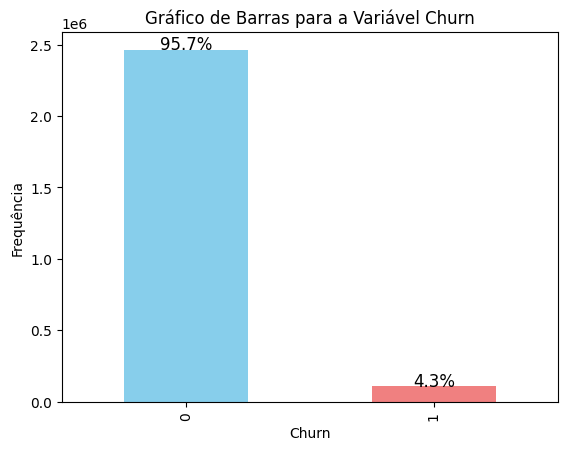

In [178]:
contagem_churn = df['RISCO_CHURN'].value_counts()
porcentagem_churn = (contagem_churn / contagem_churn.sum()) * 100
ax = contagem_churn.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Gráfico de Barras para a Variável Churn')
plt.xlabel('Churn')
plt.ylabel('Frequência')
for i, (contagem, porcentagem) in enumerate(zip(contagem_churn, porcentagem_churn)):
    ax.text(i, contagem + 10, f'{porcentagem:.1f}%', ha='center', fontsize=12)
plt.show()

## 7.1  PIPELINE DE CLASSIFICAÇÃO (CHURN)

### 7.1.1 remoção de outliers

In [179]:
colunas_necessarias = [
    'DE_FAIXA_ETARIA', 'TP_SEXO', 'DE_CONTRATACAO_PLANO', 
    'DE_ABRG_GEOGRAFICA_PLANO', 'QT_BENEFICIARIO_ATIVO', 'RISCO_CHURN'
]

if not set(colunas_necessarias).issubset(df.columns):
    missing = set(colunas_necessarias) - set(df.columns)
    print(f"Erro: Colunas ausentes - {missing}")
    exit()


In [180]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        self.Q1 = None
        self.Q3 = None

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.Q1 = X.quantile(0.25)
            self.Q3 = X.quantile(0.75)
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            filtro = ~(
                (X < (self.Q1 - self.factor * (self.Q3 - self.Q1))) | 
                (X > (self.Q3 + self.factor * (self.Q3 - self.Q1)))
            ).any(axis=1)
            return X[filtro]
        return X

### 7.1.2 definição das features e target

In [181]:
features_classificacao = [
    'DE_FAIXA_ETARIA', 'TP_SEXO', 'DE_CONTRATACAO_PLANO', 
    'DE_ABRG_GEOGRAFICA_PLANO', 'QT_BENEFICIARIO_ATIVO'
]
target = 'RISCO_CHURN'

### 7.1.2 pré processamento dos dados

In [182]:
preprocessor_classificacao = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['QT_BENEFICIARIO_ATIVO']),
        ('cat', OneHotEncoder(), ['DE_FAIXA_ETARIA', 'TP_SEXO', 'DE_CONTRATACAO_PLANO', 'DE_ABRG_GEOGRAFICA_PLANO'])
    ])


### 7.1.2 definição do modelo

In [183]:
pipeline_classificacao = Pipeline([
    ('preprocessor', preprocessor_classificacao),
    ('classifier', LogisticRegression(penalty='l2', C=0.1, max_iter=1000))
])

### 7.1.2 treinamento do modelo de classificação das features

In [184]:
try:
    pipeline_classificacao.fit(df[features_classificacao], df[target])
    df['PRED_CHURN'] = pipeline_classificacao.predict_proba(df[features_classificacao])[:, 1]
except KeyError as e:
    print(f"Erro ao treinar classificação: {e}")
    exit()

## 7.1  PIPELINE DE CLUSTERING (SEGMENTAÇÃO)

In [185]:
features_clustering = ['QT_BENEFICIARIO_ATIVO', 'DE_FAIXA_ETARIA', 'TP_SEXO']

In [186]:
preprocessor_clustering = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('outlier', OutlierRemover()),
            ('scaler', StandardScaler())
        ]), ['QT_BENEFICIARIO_ATIVO']),
        ('cat', OneHotEncoder(), ['DE_FAIXA_ETARIA', 'TP_SEXO'])
    ])

In [187]:
pipeline_clustering = Pipeline([
    ('preprocessor', preprocessor_clustering),
    ('cluster', KMeans(n_clusters=4, random_state=42))
])


In [188]:
try:
    pipeline_clustering.fit(df[features_clustering])
    df['SEGMENTO'] = pipeline_clustering.named_steps['cluster'].labels_
except KeyError as e:
    print(f"Erro ao treinar clustering: {e}")
    exit()


In [189]:
df

,NM_RAZAO_SOCIAL,MODALIDADE_OPERADORA,SG_UF,NM_MUNICIPIO,TP_SEXO,DE_FAIXA_ETARIA,DE_FAIXA_ETARIA_REAJ,TP_VIGENCIA_PLANO,DE_CONTRATACAO_PLANO,DE_SEGMENTACAO_PLANO,...,ATIVO_CAT,ADERIDO_CAT,FAIXA_ETARIA_CAT,SEXO_BINARIO,TIPO_CONTRATACAO,ABRANGENCIA_CAT,MEDIA_CANCELAMENTO_ESTADUAL,RISCO_CHURN,PRED_CHURN,SEGMENTO
0,UNIMED REGIONAL MARINGÁ COOP.DE TRABALHO MÉDICO,COOPERATIVA MÉDICA,PR,Mandaguari,M,15 a 17 anos,0 a 18 anos,P,Coletivo Empresarial,Ambulatorial + Hospitalar com obstetrícia,...,>0,0,Jovem,1,1,Nacional,0.072849,0,0.028675,0
1,IRMANDADE SANTA CASA DE MISERICÓRDIA DE MARINGÁ,FILANTROPIA,PR,Maringá,F,65 a 69 anos,59 ou mais,P,Individual ou Familiar,Ambulatorial + Hospitalar com obstetrícia,...,>0,0,Idoso,0,0,Regional (Municípios),0.072849,0,0.047277,1
2,CAIXA DE ASSISTÊNCIA DOS EMPREGADOS DA EMPRESA...,AUTOGESTÃO,PR,Londrina,M,65 a 69 anos,59 ou mais,P,Coletivo Empresarial,Ambulatorial + Hospitalar com obstetrícia,...,>0,0,Idoso,1,1,Nacional,0.072849,0,0.050345,0
3,UNIMED REGIONAL MARINGÁ COOP.DE TRABALHO MÉDICO,COOPERATIVA MÉDICA,PR,Paiçandu,F,45 a 49 anos,44 a 48 anos,P,Coletivo Empresarial,Ambulatorial + Hospitalar com obstetrícia,...,>0,0,Adulto,0,1,Regional (Municípios),0.072849,1,0.067025,1
4,DENTAL UNI - COOPERATIVA ODONTOLÓGICA,COOPERATIVA ODONTOLÓGICA,PR,Colombo,M,50 a 54 anos,54 a 58 anos,P,Individual ou Familiar,Odontológico,...,>0,0,Adulto,1,0,Estadual,0.072849,0,0.023208,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2574182,ODONTOPREV S/A,ODONTOLOGIA DE GRUPO,RS,Encantado,F,30 a 34 anos,29 a 33 anos,P,Coletivo Empresarial,Odontológico,...,>0,0,Adulto,0,1,Nacional,0.077515,0,0.038047,1
2574183,BRADESCO SAÚDE S.A.,SEGURADORA ESPECIALIZADA EM SAÚDE,RS,Porto Alegre,F,40 a 44 anos,44 a 48 anos,P,Individual ou Familiar,Referência,...,>0,0,Adulto,0,0,Nacional,0.077515,0,0.025721,3
2574184,UNIMED VITORIA COOPERATIVA DE TRABALHO MEDICO,COOPERATIVA MÉDICA,RS,Uruguaiana,F,1 a 4 anos,0 a 18 anos,P,Coletivo por Adesão,Ambulatorial + Hospitalar com obstetrícia,...,>0,0,Jovem,0,1,Nacional,0.077515,0,0.018050,1
2574185,AMIL ASSISTÊNCIA MÉDICA INTERNACIONAL S.A.,MEDICINA DE GRUPO,RS,Sananduva,F,60 a 64 anos,59 ou mais,P,Coletivo Empresarial,Ambulatorial + Hospitalar com obstetrícia,...,>0,0,Idoso,0,1,Nacional,0.077515,0,0.022457,1


COLUNAS PARA EXPORTAÇÃO 

In [190]:
colunas_exportacao = [
    'NM_RAZAO_SOCIAL',               
    'DE_FAIXA_ETARIA',                 
    'TP_SEXO',                         
    'DE_CONTRATACAO_PLANO',            
    'DE_ABRG_GEOGRAFICA_PLANO',        
    'QT_BENEFICIARIO_ATIVO',           
    'RISCO_CHURN',                     
    'PRED_CHURN',                      
    'SEGMENTO',                        
    'SEXO_BINARIO',                    
    'TIPO_CONTRATACAO',                
    'ABRANGENCIA_CAT'                  
]

In [191]:
if not set(colunas_exportacao).issubset(df.columns):
    missing = set(colunas_exportacao) - set(df.columns)
    print(f"Colunas faltantes: {missing}")
    exit()

df_export = df[colunas_exportacao]

In [192]:
df_export

,NM_RAZAO_SOCIAL,DE_FAIXA_ETARIA,TP_SEXO,DE_CONTRATACAO_PLANO,DE_ABRG_GEOGRAFICA_PLANO,QT_BENEFICIARIO_ATIVO,RISCO_CHURN,PRED_CHURN,SEGMENTO,SEXO_BINARIO,TIPO_CONTRATACAO,ABRANGENCIA_CAT
0,UNIMED REGIONAL MARINGÁ COOP.DE TRABALHO MÉDICO,15 a 17 anos,M,Coletivo Empresarial,Nacional,1,0,0.028675,0,1,1,Nacional
1,IRMANDADE SANTA CASA DE MISERICÓRDIA DE MARINGÁ,65 a 69 anos,F,Individual ou Familiar,Grupo de municípios,15,0,0.047277,1,0,0,Regional (Municípios)
2,CAIXA DE ASSISTÊNCIA DOS EMPREGADOS DA EMPRESA...,65 a 69 anos,M,Coletivo Empresarial,Nacional,22,0,0.050345,0,1,1,Nacional
3,UNIMED REGIONAL MARINGÁ COOP.DE TRABALHO MÉDICO,45 a 49 anos,F,Coletivo Empresarial,Grupo de municípios,12,1,0.067025,1,0,1,Regional (Municípios)
4,DENTAL UNI - COOPERATIVA ODONTOLÓGICA,50 a 54 anos,M,Individual ou Familiar,Estadual,10,0,0.023208,0,1,0,Estadual
...,...,...,...,...,...,...,...,...,...,...,...,...
2574182,ODONTOPREV S/A,30 a 34 anos,F,Coletivo Empresarial,Nacional,1,0,0.038047,1,0,1,Nacional
2574183,BRADESCO SAÚDE S.A.,40 a 44 anos,F,Individual ou Familiar,Nacional,1,0,0.025721,3,0,0,Nacional
2574184,UNIMED VITORIA COOPERATIVA DE TRABALHO MEDICO,1 a 4 anos,F,Coletivo por Adesão,Nacional,1,0,0.018050,1,0,1,Nacional
2574185,AMIL ASSISTÊNCIA MÉDICA INTERNACIONAL S.A.,60 a 64 anos,F,Coletivo Empresarial,Nacional,1,0,0.022457,1,0,1,Nacional


#### ENVIAR DADOS AO SERVIDOR

In [193]:
df_export.to_csv('dados_processados.csv', sep=';', index=False, encoding='utf-8')

In [196]:
query = """
INSERT INTO Beneficiarios_Processados (
    NM_RAZAO_SOCIAL, DE_FAIXA_ETARIA, TP_SEXO, DE_CONTRATACAO_PLANO,
    DE_ABRG_GEOGRAFICA_PLANO, QT_BENEFICIARIO_ATIVO, RISCO_CHURN,
    PRED_CHURN, SEGMENTO, SEXO_BINARIO, TIPO_CONTRATACAO, ABRANGENCIA_CAT
) 
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
"""

try:
    conn = pyodbc.connect(conn_str)
    cursor = conn.cursor()
    cursor.fast_executemany = True


    chunksize = 100000
    for chunk in pd.read_csv(
        'dados_processados.csv',
        sep=';',
        encoding='utf-8',
        chunksize=chunksize,
        on_bad_lines='warn',
        engine='python',
        quoting=3
    ):
        chunk = chunk.fillna('')
        
        dados = [
            tuple(row) for row in chunk[[
                'NM_RAZAO_SOCIAL', 'DE_FAIXA_ETARIA', 'TP_SEXO',
                'DE_CONTRATACAO_PLANO', 'DE_ABRG_GEOGRAFICA_PLANO',
                'QT_BENEFICIARIO_ATIVO', 'RISCO_CHURN', 'PRED_CHURN',
                'SEGMENTO', 'SEXO_BINARIO', 'TIPO_CONTRATACAO', 'ABRANGENCIA_CAT'
            ]].itertuples(index=False)
        ]
        
        cursor.executemany(query, dados)
        conn.commit()
        print(f"Chunk de {len(dados)} registros inserido!")

except Exception as e:
    print(f"Erro: {str(e)}")
    conn.rollback()

finally:
    cursor.close()
    conn.close()

print("Carga concluída!")

Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 100000 registros inserido!
Chunk de 74187 registros inserido!
Carga concluída!
